In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
import xrft
import gsw
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from dask.diagnostics import ProgressBar

# Load data

In [6]:
from intake import open_catalog
import xmitgcm.llcreader as llcreader
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [10]:
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()
ds = xr.merge([u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])

coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)

In [11]:
llcw0=ds.sel(time=slice('2012-02-01','2012-04-30')).isel(j=slice(9555,10198-115),j_g=slice(9555,10198-115),
                                            i=slice(15355+170,15845),i_g=slice(15355+170,15845))
llcw0

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 320, j: 528, time: 2160, i: 320, j_g: 528)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 15525 15526 15527 15528 ... 15841 15842 15843 15844
  * j        (j) int64 9555 9556 9557 9558 9559 ... 10079 10080 10081 10082
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00
  * i        (i) int64 15525 15526 15527 15528 15529 ... 15841 15842 15843 15844
  * j_g      (j_g) int64 9555 9556 9557 9558 9559 ... 10079 10080 10081 10082
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 528, 320), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 528, 320), meta=np.ndarray>

In [12]:
dxC_sel = coords.dxC.isel(i_g=slice(15355+170,15845), j=slice(9555,10198-115))
dyG_sel = coords.dyG.isel(i_g=slice(15355+170,15845), j=slice(9555,10198-115))
dyC_sel = coords.dyC.isel(i=slice(15355+170,15845), j_g=slice(9555,10198-115))
dxG_sel = coords.dxG.isel(i=slice(15355+170,15845), j_g=slice(9555,10198-115))
XC_sel = coords.XC.isel(i=slice(15355+170,15845), j=slice(9555,10198-115))
YC_sel = coords.YC.isel(i=slice(15355+170,15845), j=slice(9555,10198-115))
dyG_sel= coords.dyG.isel(i_g=slice(15355+170,15845), j=slice(9555,10198-115))


In [13]:
llcw2 = xr.merge([llcw0,  dxC_sel, dyC_sel, dxG_sel,
                      dyG_sel,XC_sel, YC_sel,dyG_sel])
llcw2

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 320, j: 528, time: 2160, i: 320, j_g: 528)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 15525 15526 15527 15528 ... 15841 15842 15843 15844
  * j        (j) int64 9555 9556 9557 9558 9559 ... 10079 10080 10081 10082
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00
  * i        (i) int64 15525 15526 15527 15528 15529 ... 15841 15842 15843 15844
  * j_g      (j_g) int64 9555 9556 9557 9558 9559 ... 10079 10080 10081 10082
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 528, 320), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 528, 320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(528, 320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(528, 320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(528, 320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(528, 320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(528, 320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(528, 320), meta=np.ndarray>

In [14]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
#     ('Z',): ['drC'], # Z distances
    # ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}


In [15]:
gridllc = Grid(llcw2, periodic=[],
               coords={
#                        'Z':{'center':'k','outer':'k_p1'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )

In [17]:
llcw2.U

<xarray.DataArray 'U' (time: 2160, j: 528, i_g: 320)>
dask.array<getitem, shape=(2160, 528, 320), dtype=float32, chunksize=(1, 528, 320), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 15525 15526 15527 15528 ... 15841 15842 15843 15844
  * j        (j) int64 9555 9556 9557 9558 9559 ... 10079 10080 10081 10082
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00

In [16]:
gridllc.interp(llcw2.U,'X',boundary='extend') # 坐标轴的变换

<xarray.DataArray 'U' (time: 2160, j: 528, i: 320)>
dask.array<interp_left_to_center, shape=(2160, 528, 320), dtype=float32, chunksize=(1, 528, 320), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 9555 9556 9557 9558 9559 ... 10079 10080 10081 10082
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00
  * i        (i) int64 15525 15526 15527 15528 15529 ... 15841 15842 15843 15844

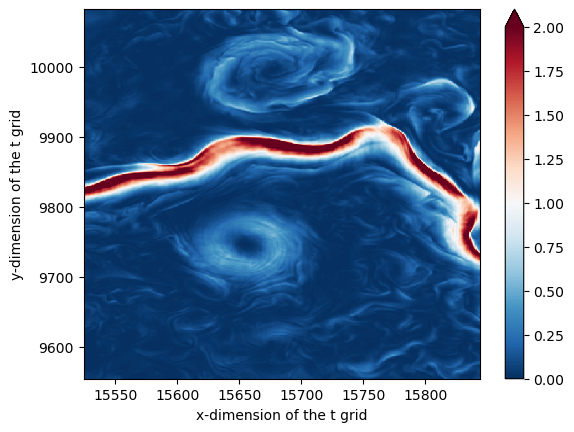

In [18]:
tmp=.5*(gridllc.interp(llcw2.U.isel(time=0)**2,'X',boundary='extend')
                       + gridllc.interp(llcw2.V.isel(time=0)**2,'Y',boundary='extend')
                      )
tmp.plot(cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

CPU times: user 13.1 s, sys: 2.44 s, total: 15.5 s
Wall time: 21.1 s


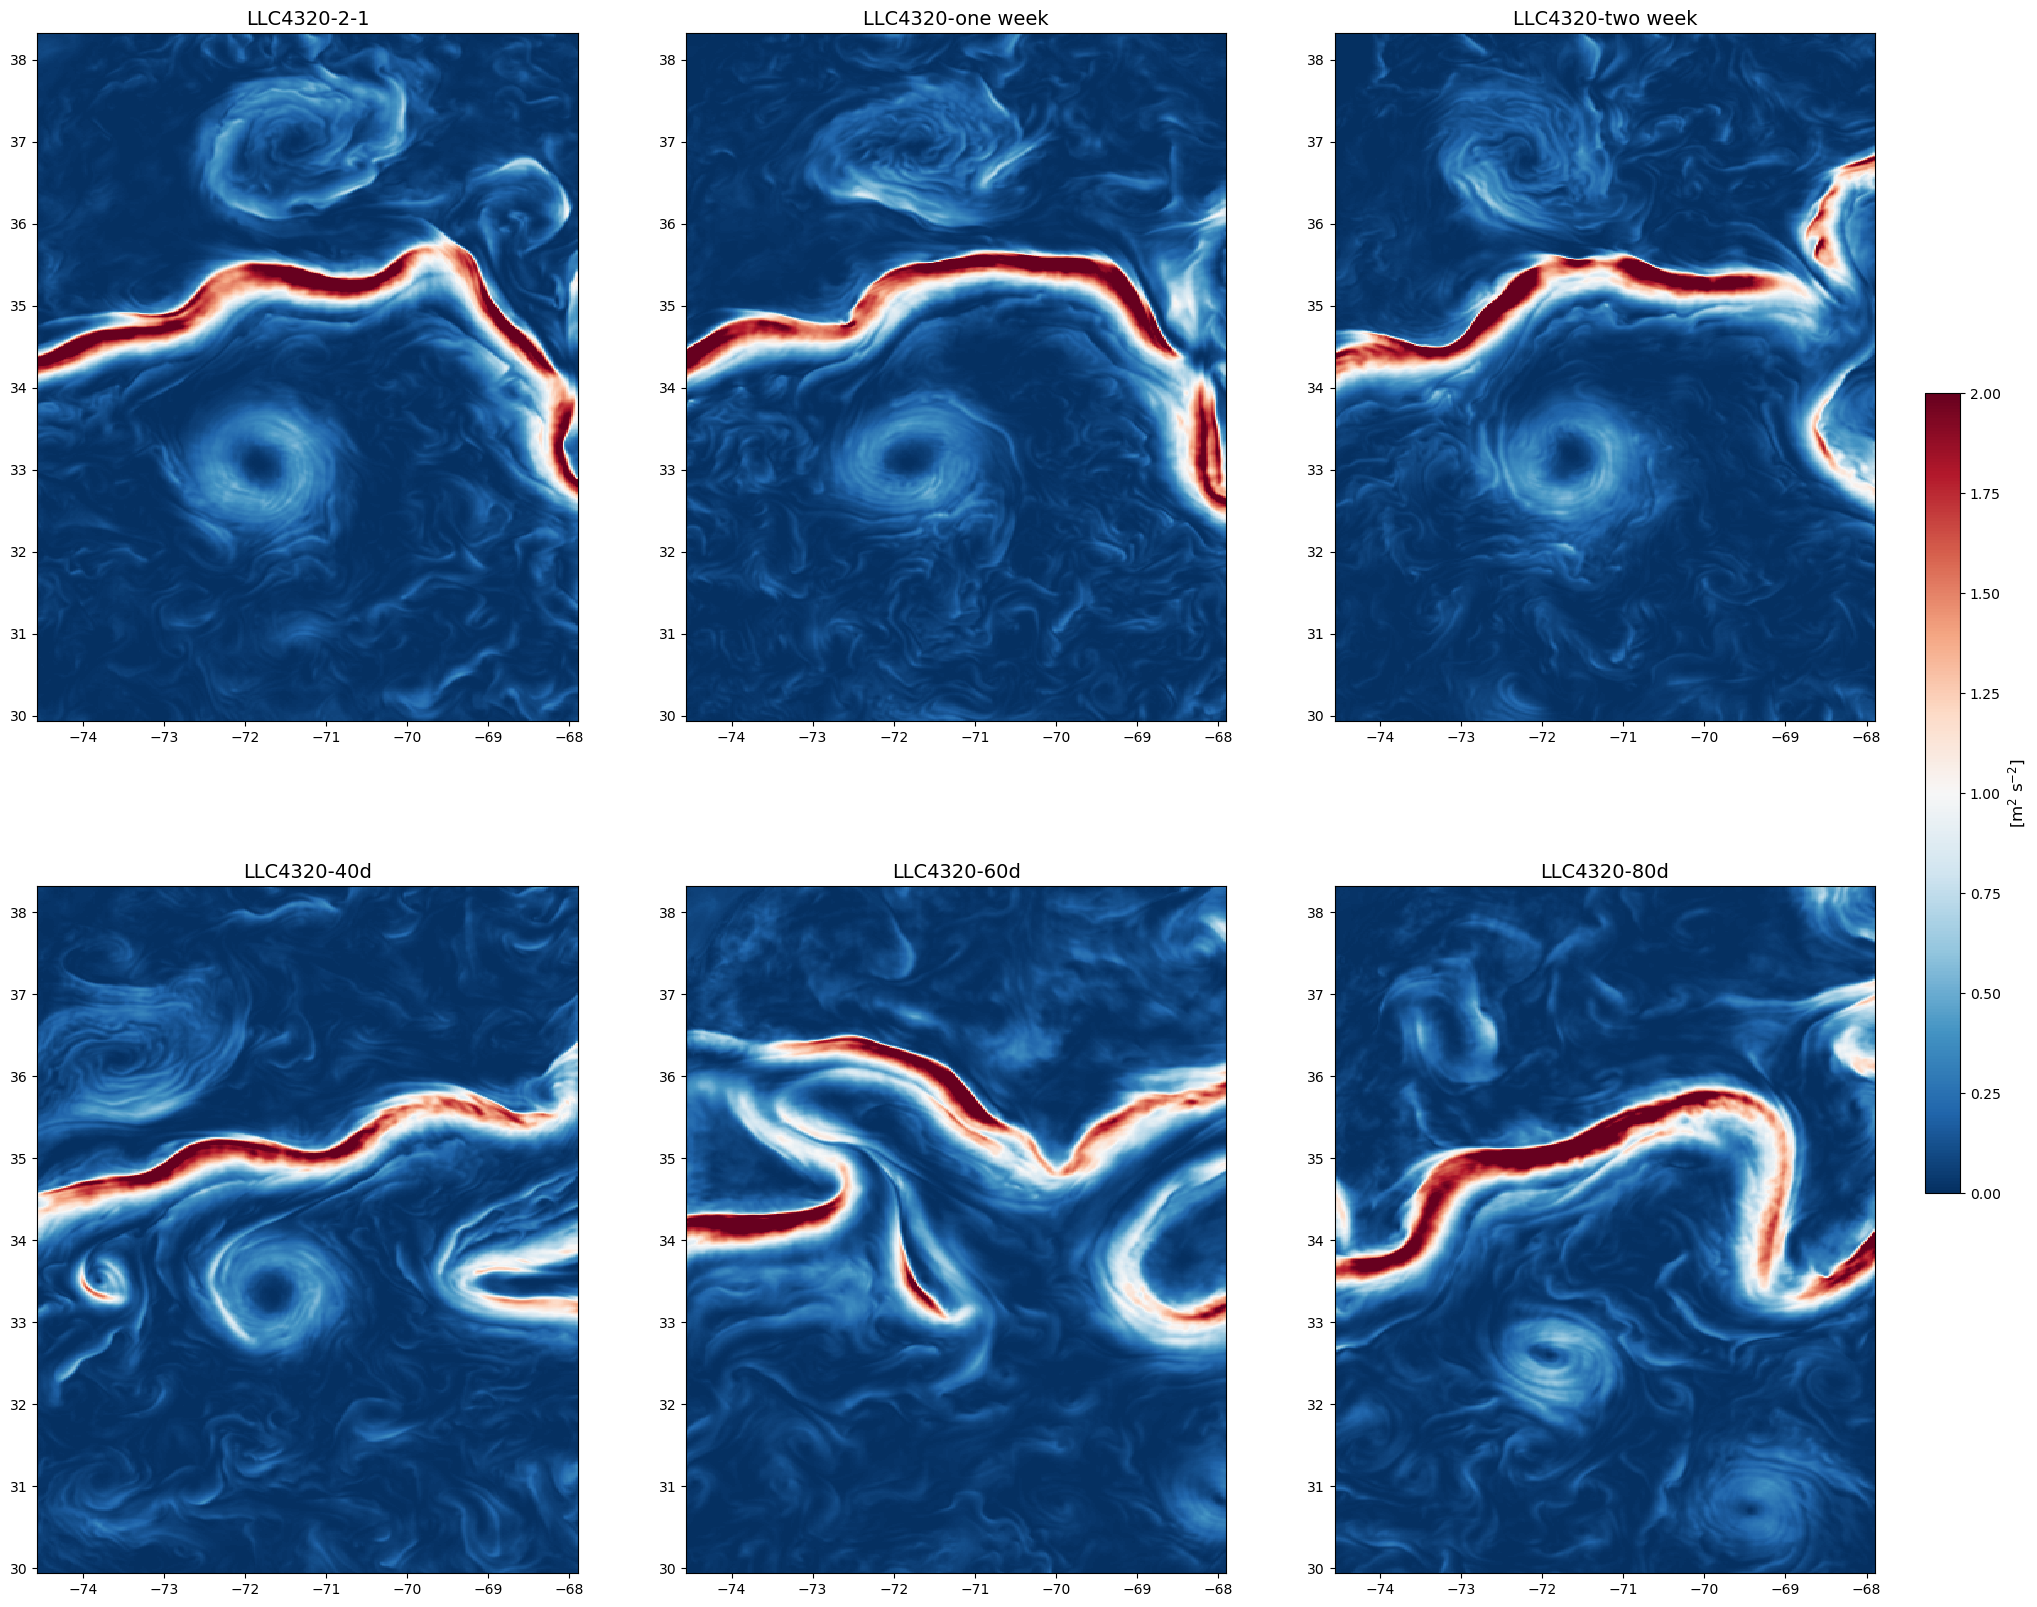

In [19]:
%%time
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,20))
# fig.set_tight_layout(True)

im = axes[0,0].pcolormesh(llcw2.XC, llcw2.YC,
                   .5*(gridllc.interp(llcw2.U.isel(time=0)**2,'X',boundary='extend')
                       + gridllc.interp(llcw2.V.isel(time=0)**2,'Y',boundary='extend')
                      ), 
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[0,1].pcolormesh(llcw2.XC, llcw2.YC,
                   .5*(gridllc.interp(llcw2.U.isel(time=24*7)**2,'X',boundary='extend')
                       + gridllc.interp(llcw2.V.isel(time=24*7)**2,'Y',boundary='extend')
                      ), 
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[0,2].pcolormesh(llcw2.XC, llcw2.YC,
                   .5*(gridllc.interp(llcw2.U.isel(time=24*14)**2,'X',boundary='extend')
                       + gridllc.interp(llcw2.V.isel(time=24*14)**2,'Y',boundary='extend')
                      ), 
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[1,0].pcolormesh(llcw2.XC, llcw2.YC,
                   .5*(gridllc.interp(llcw2.U.isel(time=24*40)**2,'X',boundary='extend')
                       + gridllc.interp(llcw2.V.isel(time=24*40)**2,'Y',boundary='extend')
                      ), 
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[1,1].pcolormesh(llcw2.XC, llcw2.YC,
                   .5*(gridllc.interp(llcw2.U.isel(time=24*60)**2,'X',boundary='extend')
                       + gridllc.interp(llcw2.V.isel(time=24*60)**2,'Y',boundary='extend')
                      ), 
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[1,2].pcolormesh(llcw2.XC, llcw2.YC,
                   .5*(gridllc.interp(llcw2.U.isel(time=24*80)**2,'X',boundary='extend')
                       + gridllc.interp(llcw2.V.isel(time=24*80)**2,'Y',boundary='extend')
                      ), 
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

axes[0,0].set_title(r"LLC4320-2-1", fontsize=14)
axes[0,1].set_title(r"LLC4320-one week", fontsize=14)
axes[0,2].set_title(r"LLC4320-two week", fontsize=14)
axes[1,0].set_title(r"LLC4320-40d", fontsize=14)
axes[1,1].set_title(r"LLC4320-60d", fontsize=14)
axes[1,2].set_title(r"LLC4320-80d", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.24) 
cbax = fig.add_axes([0.88, 0.3, 0.014, 0.4])
cbar = fig.colorbar(im, orientation='vertical', cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-2}$]", fontsize=12)
fig.savefig("test_rasterization.png", dpi=150)

# Assume a local Cartesian plane

In [20]:
%%time
Ny1 = len(llcw2.j)
Nx1 = len(llcw2.i_g)
dx1 = llcw2.dxC.mean(skipna=True).load()
dy1 = llcw2.dyG.mean(skipna=True).load()

CPU times: user 339 ms, sys: 145 ms, total: 484 ms
Wall time: 935 ms


In [21]:
dy1.values

array(1764.6693, dtype=float32)

In [22]:
with ProgressBar():
    U_llc = xr.DataArray(llcw2.U, dims=['time','YC','XC'],
                            coords={'time':np.arange(len(llcw2.U.time))*3600, # second unit
                                    'YC':np.arange(0,Ny1*dy1,dy1),
                                    'XC':np.arange(0,Nx1*dx1,dx1)} # Disctance in m
                           ).chunk({'time':100,'YC':-1,'XC':-1})

    V_llc = xr.DataArray(llcw2.U, dims=['time','YC','XC'],
                            coords={'time':np.arange(len(llcw2.U.time))*3600,
                                    'YC':np.arange(0,Ny1*dy1,dy1),
                                    'XC':np.arange(0,Nx1*dx1,dx1)}
                           ).chunk({'time':100,'YC':-1,'XC':-1})

# Take the $\omega$-$k$ Fourier transform

In [23]:
%%time
# FFT. 先进行空间的，在进行时间的，最后得到的两个都有
Fu_llc = xrft.fft(xrft.fft(U_llc.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='constant', 
                              true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                     dim=['time'], window='hann', detrend='constant', 
                     true_phase=True, true_amplitude=True
                    )

Fu_lls = Fu_llc.isel(freq_time=slice(len(Fu_llc.freq_time)//2,None)) * 2

Fv_llc = xrft.fft(xrft.fft(V_llc.fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='constant', 
                              true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':200,'freq_XC':200}),
                     dim=['time'], window='hann', detrend='constant', 
                     true_phase=True, true_amplitude=True
                    )

Fv_llc = Fv_llc.isel(freq_time=slice(len(Fv_llc.freq_time)//2,None)) * 2

CPU times: user 120 ms, sys: 2.21 ms, total: 122 ms
Wall time: 119 ms


In [24]:
Fv_llc

<xarray.DataArray (freq_time: 1080, freq_YC: 528, freq_XC: 320)>
dask.array<mul, shape=(1080, 528, 320), dtype=complex128, chunksize=(1080, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * freq_YC    (freq_YC) float64 -0.0002833 -0.0002823 ... 0.0002812 0.0002823
  * freq_XC    (freq_XC) float64 -0.0002612 -0.0002596 ... 0.000258 0.0002596
  * freq_time  (freq_time) float64 0.0 1.286e-07 ... 0.0001386 0.0001388

# Function to isotropize the power spectra

In [25]:
def _binned_agg(
    array: np.ndarray,
    indices: np.ndarray,
    num_bins: int,
    *,
    func,
    fill_value,
    dtype,
) -> np.ndarray:
    """NumPy helper function for aggregating over bins."""

    try:
        import numpy_groupies
    except ImportError:
        raise ImportError(
            "This function requires the `numpy_groupies` package to be installed. "
            + "Please install it with pip or conda."
        )

    mask = np.logical_not(np.isnan(indices))
    int_indices = indices[mask].astype(int)
    shape = array.shape[: -indices.ndim] + (num_bins,)
    result = numpy_groupies.aggregate(
        int_indices,
        array[..., mask],
        func=func,
        size=num_bins,
        fill_value=fill_value,
        dtype=dtype,
        axis=-1,
    )
    return result


def _groupby_bins_agg(
    array: xr.DataArray,
    group: xr.DataArray,
    bins,
    func="sum",
    fill_value=0,
    dtype=None,
    **cut_kwargs,
) -> xr.DataArray:
    """Faster equivalent of Xarray's groupby_bins(...).sum()."""
    # https://github.com/pydata/xarray/issues/4473
    binned = pd.cut(np.ravel(group), bins, **cut_kwargs)
    new_dim_name = group.name + "_bins"
    indices = group.copy(data=binned.codes.reshape(group.shape))

    result = xr.apply_ufunc(
        _binned_agg,
        array,
        indices,
        input_core_dims=[indices.dims, indices.dims],
        output_core_dims=[[new_dim_name]],
        output_dtypes=[array.dtype],
        dask_gufunc_kwargs=dict(
            allow_rechunk=True,
            output_sizes={new_dim_name: binned.categories.size},
        ),
        kwargs={
            "num_bins": binned.categories.size,
            "func": func,
            "fill_value": fill_value,
            "dtype": dtype,
        },
        dask="parallelized",
    )
    result.coords[new_dim_name] = binned.categories
    return result


def isotropize(ps, fftdim, nfactor=4, **kwargs):
    """
    Isotropize a 2D power spectrum or cross spectrum
    by taking an azimuthal average.
    .. math::
        \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2
    where :math:`N` is the number of azimuthal bins.
    Parameters
    ----------
    ps : `xarray.DataArray`
        The power spectrum or cross spectrum to be isotropized.
    fftdim : list
        The fft dimensions overwhich the isotropization must be performed.
    nfactor : int, optional
        Ratio of number of bins to take the azimuthal averaging with the
        data size. Default is 4.
    """

    # compute radial wavenumber bins
    k = ps[fftdim[1]]
    l = ps[fftdim[0]]

    N = [k.size, l.size]
    nbins = int(min(N) / nfactor)
    freq_r = np.sqrt(k ** 2 + l ** 2).rename("freq_r")
    kr = _groupby_bins_agg(freq_r, freq_r, bins=nbins, func="mean")

    if "truncate" in kwargs:
        if truncate:
            if k.max() > l.max():
                kmax = l.max()
            else:
                kmax = k.max()
            kr = kr.where(kr <= kmax)
        else:
            pass

    iso_ps = (
        _groupby_bins_agg(ps, freq_r, bins=nbins, func="mean")
        .rename({"freq_r_bins": "freq_r"})
        .drop_vars("freq_r")
    )
    iso_ps.coords["freq_r"] = kr.data
    if "truncate" in kwargs:
        if truncate:
            return (iso_ps * iso_ps.freq_r).dropna("freq_r")
    else:
        return iso_ps * iso_ps.freq_r

In [26]:
def density(ps, dim):
    ff = np.prod([float(ps[d].spacing) for d in dim])
    return ps * ff

In [27]:
with ProgressBar():
    isoFu_llc = isotropize(density(np.abs(Fu_llc.chunk({'freq_time':10}))**2,
                                      ['freq_time','freq_YC','freq_XC']), 
                              ['freq_YC','freq_XC'], nfactor=4, 
                              kwargs={'truncate':True}
                             ).compute()
    isoFv_llc = isotropize(density(np.abs(Fv_llc.chunk({'freq_time':10}))**2,
                                      ['freq_time','freq_YC','freq_XC']),  
                              ['freq_YC','freq_XC'], nfactor=4, 
                              kwargs={'truncate':True}
                             ).compute()

[########################################] | 100% Completed | 190.16 s
[########################################] | 100% Completed | 186.18 s


In [28]:
o1 = 25.81933871**-1
k1 = 23.93447213**-1
m2 = 12.4206012**-1
s2 = 12**-1
cs = 0.30404039  # 10th internal wave phase speed

# Plot the spectra

In [29]:
def plot(isoF, omega, f, title=r'eNATL60'):
    fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
    fig.set_tight_layout(True)

    im = ax1.pcolormesh(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
                        isoF.freq_time.isel(freq_time=slice(1,None))*3600,
                        isoF.isel(freq_time=slice(1,None),freq_r=slice(1,None)), 
                        cmap='inferno', 
                        norm=clr.LogNorm(vmin=5e-1, vmax=5e6), 
                        shading='auto', rasterized=True
                       )
    # ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
    #          xr.ones_like(isoF.freq_r.isel(freq_r=slice(1,None)))
    #          * (f/2/np.pi).mean() * 3600,
    #          c='grey'
    #         )
    # ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
    #          np.sqrt(((f.isel(YC=0))**2).mean() 
    #                  + cs**2*(isoF.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
    #                 )/2/np.pi * 3600,
    #          'w', lw=1
    #         )
    # ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
    #          np.sqrt(((f.isel(YC=0))**2).mean() 
    #                  + (cs*10)**2*(isoF.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
    #                 )/2/np.pi * 3600,
    #          'w', lw=1
    #         )
    # ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
    #          np.sqrt(((f.isel(YC=0))**2).mean() 
    #                  + (cs*5)**2*(isoF.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
    #                 )/2/np.pi * 3600,
    #          'w', lw=1
    #         )
    # ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
    #          np.sqrt(((f.isel(YC=0))**2).mean() 
    #                  + (cs*2.5)**2*(isoF.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
    #                 )/2/np.pi * 3600,
    #          'w', lw=1
    #         )
    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             omega*3600,
             'k', lw=3
            )

    ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             xr.ones_like(isoF.freq_r.isel(freq_r=slice(1,None)))*m2,
             'w--'
            )
    # ax1.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
    #          xr.ones_like(isoF.freq_r.isel(freq_r=slice(1,None)))*s2,
    #          'w--'
    #         )

    ax1.set_ylim([5e-3,5e-1])
    ax1.set_xlim([7e-3,7e-1])
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel(r"$\omega$ [cph]", fontsize=13)
    ax1.set_xlabel(r"$k$ [cpkm]", fontsize=13)

    cbar = fig.colorbar(im, ax=ax1)
    cbar.set_label(r"[(m$^2$ s$^{-2}$)$/$cpm$/$cps]", fontsize=12)

    ax2.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             (isoF.isel(freq_time=slice(1,None),freq_r=slice(1,None)).where(isoF.freq_time<omega)
              * np.diff(isoF.freq_time)[0]
             ).sum('freq_time',skipna=True),
             c='k', label=r"Balanced"
            )
    ax2.plot(isoF.freq_r.isel(freq_r=slice(1,None))*1e3,
             (isoF.isel(freq_time=slice(1,None),freq_r=slice(1,None)).where(isoF.freq_time>omega)
              * np.diff(isoF.freq_time)[0]
             ).sum('freq_time',skipna=True),
             c='grey', label=r"Unbalanced"
            )
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlim([6e-3,8e-1])
    ax2.set_ylabel(r"[(m$^2$ s$^{-2}$)$/$cpm]", fontsize=13)
    ax2.set_xlabel(r"$k$ [cpkm]", fontsize=13)
    ax2.legend(loc='lower left', fontsize=12)
    
    fig.suptitle(title, fontsize=15)

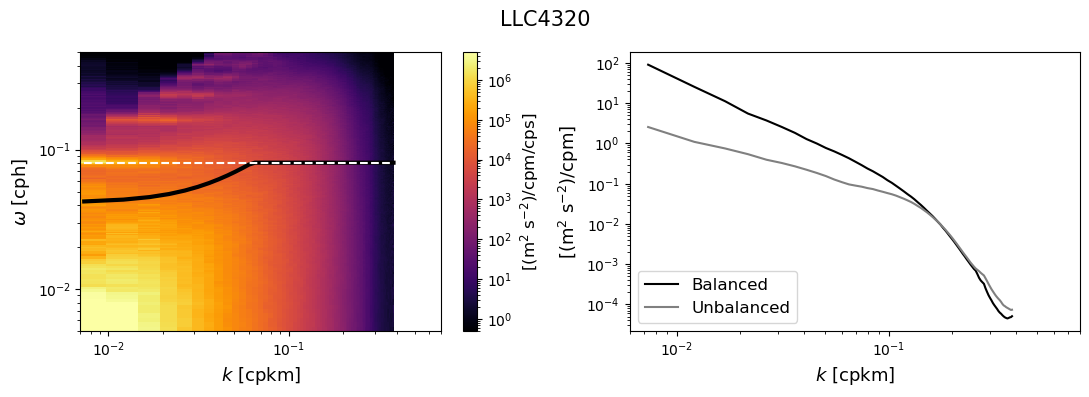

In [30]:
enatlf = xr.DataArray(xr.apply_ufunc(gsw.f, llcw2.YC, dask='parallelized').data,
                      dims=['YC','XC'], coords={'YC':U_llc.YC,'XC':U_llc.XC})
omega = np.sqrt(((enatlf.isel(YC=0))**2).mean() 
                + cs**2*(isoFu_llc.freq_r.isel(freq_r=slice(1,None))*2*np.pi)**2
               )/2/np.pi
omega = xr.DataArray(np.minimum(omega, m2/3600), dims='freq_r',
                     coords={'freq_r':isoFu_llc.freq_r.isel(freq_r=slice(1,None))}
                    )
plot(.5*(isoFu_llc + isoFv_llc),
     omega, enatlf,title=r"LLC4320")